<a href="https://colab.research.google.com/github/ChrisCliadakis/Physics-Informed-Neural-Networks/blob/main/PINN_PM(X%2CY).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch [0/1000], Loss: 43.29186248779297
Epoch [100/1000], Loss: 2.819840574375121e-06
Epoch [200/1000], Loss: 2.819840574375121e-06
Epoch [300/1000], Loss: 2.819840574375121e-06
Epoch [400/1000], Loss: 2.819840574375121e-06
Epoch [500/1000], Loss: 2.819840574375121e-06
Epoch [600/1000], Loss: 2.819840574375121e-06
Epoch [700/1000], Loss: 2.819840574375121e-06
Epoch [800/1000], Loss: 2.819840574375121e-06
Epoch [900/1000], Loss: 2.819840574375121e-06


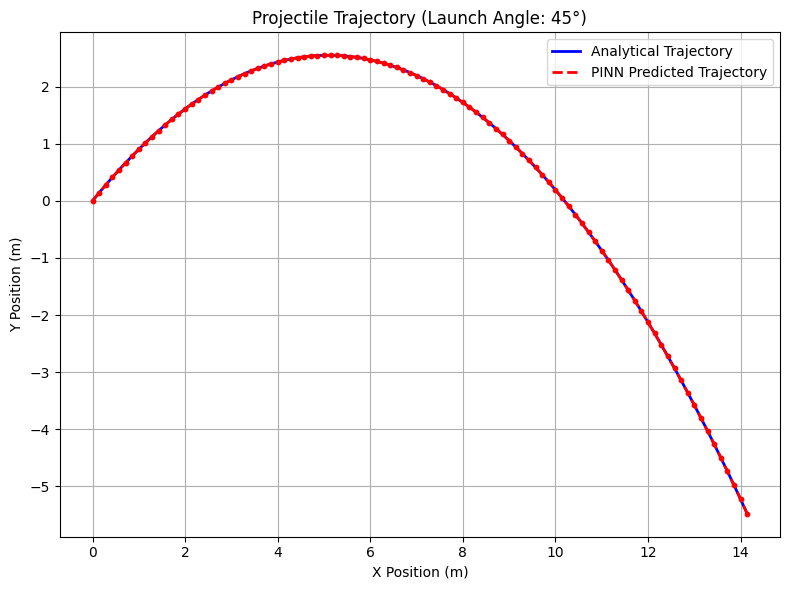

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden1 = nn.Linear(1, 50)
        self.hidden2 = nn.Linear(50, 50)
        self.hidden3 = nn.Linear(50, 50)
        self.hidden4 = nn.Linear(50, 50)
        self.hidden5 = nn.Linear(50, 50)
        self.output_y = nn.Linear(50, 1)
        self.output_x = nn.Linear(50, 1)  # Changed from output_v to output_x

    def forward(self, t):
        t = torch.tanh(self.hidden1(t))
        y = self.output_y(t)
        x = self.output_x(t)  # Changed from v to x
        return x, y  # Changed order to x, y

def compute_loss(model, t_train, g=9.81, x0=0, v0=10, angle=45):
    angle_rad = np.radians(angle)
    vx0 = v0 * np.cos(angle_rad)  # Changed to vx0
    vy0 = v0 * np.sin(angle_rad)

    x_pred, y_pred = model(t_train)  # Changed order to x_pred, y_pred

    dxdt = torch.autograd.grad(outputs=x_pred, inputs=t_train, grad_outputs=torch.ones_like(x_pred),
                               create_graph=True, retain_graph=True)[0]
    dydt = torch.autograd.grad(outputs=y_pred, inputs=t_train, grad_outputs=torch.ones_like(y_pred),
                               create_graph=True, retain_graph=True)[0]

    d2ydt2 = torch.autograd.grad(outputs=dydt, inputs=t_train, grad_outputs=torch.ones_like(dydt),
                                 create_graph=True, retain_graph=True)[0]

    ode_residual_y = d2ydt2 + g
    ode_residual_x = dxdt - vx0  # Changed to enforce constant horizontal velocity

    bc_loss = (x_pred[0] - x0)**2 + (y_pred[0] - 0)**2 + (dxdt[0] - vx0)**2 + (dydt[0] - vy0)**2

    loss = torch.mean(ode_residual_y**2) + torch.mean(ode_residual_x**2) + bc_loss
    return loss

# The rest of the code remains largely the same, with minor adjustments to variable names and plotting

t_train = torch.linspace(0, 2, 100, requires_grad=True).view(-1, 1)

model = PINN()
optimizer = optim.LBFGS(model.parameters(), lr=0.1, max_iter=20, history_size=50)

def train(model, optimizer, t_train, epochs=1000, angle=45):
    def closure():
        optimizer.zero_grad()
        loss = compute_loss(model, t_train, angle=angle)
        loss.backward()
        return loss

    for epoch in range(epochs):
        optimizer.step(closure)
        if epoch % 100 == 0:
            loss_value = compute_loss(model, t_train, angle=angle).item()
            print(f"Epoch [{epoch}/{epochs}], Loss: {loss_value}")

train(model, optimizer, t_train, epochs=1000, angle=45)

t_plot = torch.linspace(0, 2, 100).view(-1, 1)
x_pred_plot, y_pred_plot = model(t_plot)

def analytical_solution(t, x0=0, y0=0, v0=10, g=9.81, angle=45):
    angle_rad = np.radians(angle)
    vx0 = v0 * np.cos(angle_rad)
    vy0 = v0 * np.sin(angle_rad)
    x = x0 + vx0 * t
    y = y0 + vy0 * t - 0.5 * g * t**2
    return x, y

x_analytical, y_analytical = analytical_solution(t_plot.numpy(), angle=45)

plt.figure(figsize=(8, 6))

plt.plot(x_analytical, y_analytical, label="Analytical Trajectory", color='blue', linestyle='-', linewidth=2)
plt.plot(x_pred_plot.detach().numpy(), y_pred_plot.detach().numpy(), label="PINN Predicted Trajectory", color='red', linestyle='--', linewidth=2)
plt.scatter(x_pred_plot.detach().numpy(), y_pred_plot.detach().numpy(), color='red', s=10, zorder=5)
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Projectile Trajectory (Launch Angle: 45°)')
plt.legend(loc='best')
plt.grid(True)

plt.tight_layout()
plt.show()
